In [ ]:
#설치후 세션 다시시작
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (29.1 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 처리
import pandas as pd
import numpy as np

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score

# 모델
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# "UID" 컬럼 처리
test_uid = test_df[["UID"]]
train_df.drop(columns=["UID"], inplace=True)
test_df.drop(columns=["UID"], inplace=True)

# X, y 분리
X = train_df.drop(columns=["채무 불이행 여부"])
y = train_df["채무 불이행 여부"]

In [3]:
# 파생 변수 생성: "마지막 연체 이후 경과 개월 수"가 0이면 "연체 없음" 컬럼 추가
X["연체 없음"] = (X["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
test_df["연체 없음"] = (test_df["마지막 연체 이후 경과 개월 수"] == 0).astype(int)

In [4]:
drop_cols = ['대출 목적', '개설된 신용계좌 수']

X.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

In [5]:
# 범주형 데이터 처리

job_tenure_map = {
    "1년 미만": 1, "1년": 1, "2년": 2, "3년": 3, "4년": 4, "5년": 5, "6년": 6, "7년": 7, "8년": 8, "9년": 9, "10년 이상":10
}


categorical_cols = ["주거 형태", "현재 직장 근속 연수", "대출 목적", "대출 상환 기간"]

# 라벨 인코딩 (현재 직장 근속 연수)
job_tenure = "현재 직장 근속 연수"
X[job_tenure] = X[job_tenure].map(job_tenure_map)
test_df[job_tenure] = test_df[job_tenure].map(job_tenure_map)

# 원-핫 인코딩 적용
X = pd.get_dummies(X, columns=["주거 형태",  "대출 상환 기간"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["주거 형태",  "대출 상환 기간"], drop_first=True)

In [6]:
log_columns = ["현재 미상환 신용액", "월 상환 부채액", "현재 대출 잔액"]

# winsorize 기준을 train 데이터 기준으로 계산 후 test에도 동일하게 적용
for col in log_columns:
    # 분위수 계산
    lower = X[col].quantile(0.01)
    upper = X[col].quantile(0.99)

    # winsorize
    X[col] = X[col].clip(lower, upper)
    test_df[col] = test_df[col].clip(lower, upper)

    # 로그 변환
    X[col] = np.log1p(X[col])
    test_df[col] = np.log1p(test_df[col])

# IQR 기반 이상치 처리 (연간 소득)
Q1 = X["연간 소득"].quantile(0.25)
Q3 = X["연간 소득"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

X["연간 소득"] = np.where(X["연간 소득"] > upper_bound, upper_bound, X["연간 소득"])
test_df["연간 소득"] = np.where(test_df["연간 소득"] > upper_bound, upper_bound, test_df["연간 소득"])


In [7]:
knn_imputer = KNNImputer(n_neighbors=10)
X_imputed = knn_imputer.fit_transform(X)
test_imputed = knn_imputer.transform(test_df)

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
test_scaled = scaler.transform(test_imputed)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

sgd_model = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, random_state=42)

sgd_model.fit(X_train, y_train)
print("Train Score:", sgd_model.score(X_train, y_train))
print("Test Score :", sgd_model.score(X_test, y_test))

Train Score: 0.672875
Test Score : 0.646


In [10]:
# 테스트 데이터 예측 & 저장
test_preds = sgd_model.predict_proba(test_scaled)[:, 1]
submission = pd.DataFrame({"UID": test_uid["UID"], "채무 불이행 확률": test_preds})
submission.to_csv("submission.csv", index=False)
print("✅ 제출 파일 생성 완료! 'submission.csv' 저장되었습니다.")

✅ 제출 파일 생성 완료! 'submission.csv' 저장되었습니다.


✅ Test ROC-AUC: 0.6386527882644807


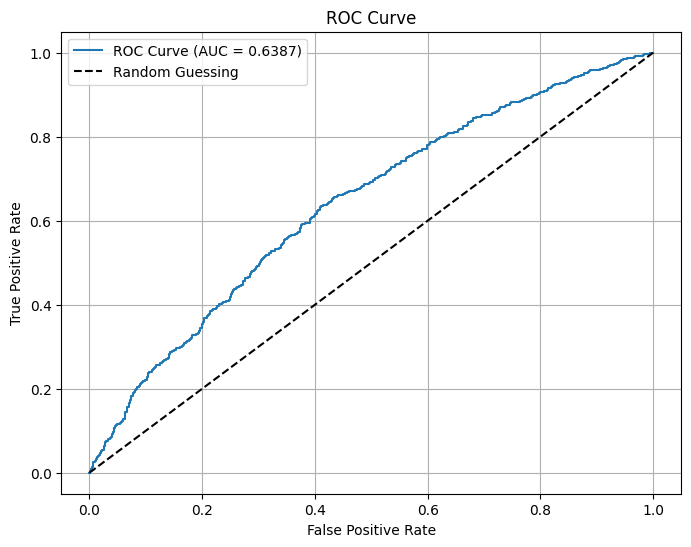

In [11]:
# ✅ ROC-AUC 계산
y_test_proba = sgd_model.predict_proba(X_test)[:, 1]
print("✅ Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))


# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
import pandas as pd

# 특성 이름 가져오기 (X는 원본 컬럼명 기준이어야 함)
feature_names = X.columns

# SGDClassifier 계수 가져오기
coefficients = sgd_model.coef_[0]  # 1차원 벡터

# 판다스로 정리
feature_importance = pd.Series(coefficients, index=feature_names)

# 중요도 순 정렬
feature_importance_sorted = feature_importance.sort_values(ascending=False)

# 상위 10개 출력
print("🔼 채무 불이행 가능성을 높이는 변수 상위 10개:")
print(feature_importance_sorted.head(5))

# 하위 10개 출력
print("\n🔽 채무 불이행 가능성을 낮추는 변수 하위 10개:")
print(feature_importance_sorted.tail(5))

🔼 채무 불이행 가능성을 높이는 변수 상위 10개:
개인 파산 횟수                 0.376804
현재 대출 잔액                 0.317103
대출 상환 기간_장기 상환           0.312500
현재 미상환 신용액               0.208595
주거 형태_주택 담보 대출 (거주 중)   -0.039384
dtype: float64

🔽 채무 불이행 가능성을 낮추는 변수 하위 10개:
마지막 연체 이후 경과 개월 수        -0.164904
연체 없음                    -0.176679
주거 형태_주택 담보 대출 (비거주 중)   -0.189028
체납 세금 압류 횟수              -0.192496
연간 소득                    -0.549201
dtype: float64


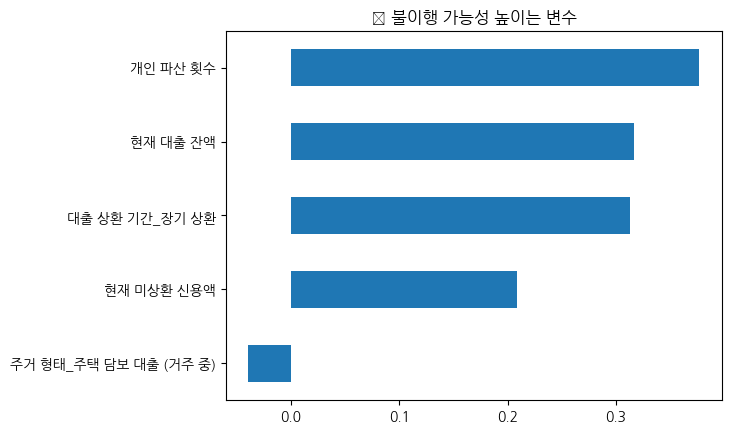

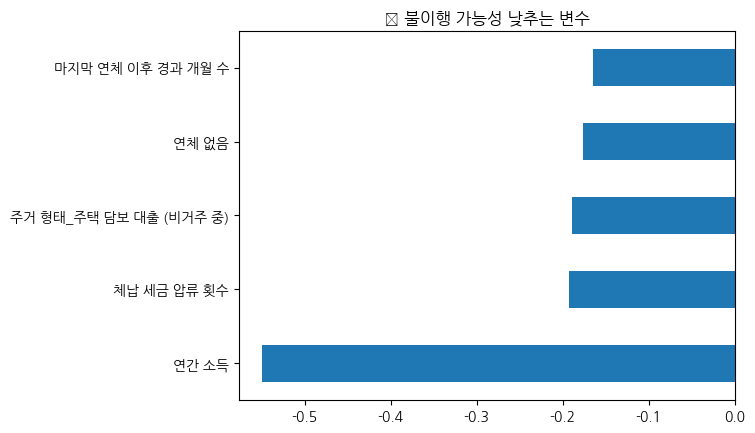

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
# 상위 10개 시각화
feature_importance_sorted.head(5).plot(kind='barh', title='🔼 불이행 가능성 높이는 변수')
plt.gca().invert_yaxis()
plt.show()

# 하위 10개 시각화
feature_importance_sorted.tail(5).plot(kind='barh', title='🔽 불이행 가능성 낮추는 변수')
plt.gca().invert_yaxis()
plt.show()

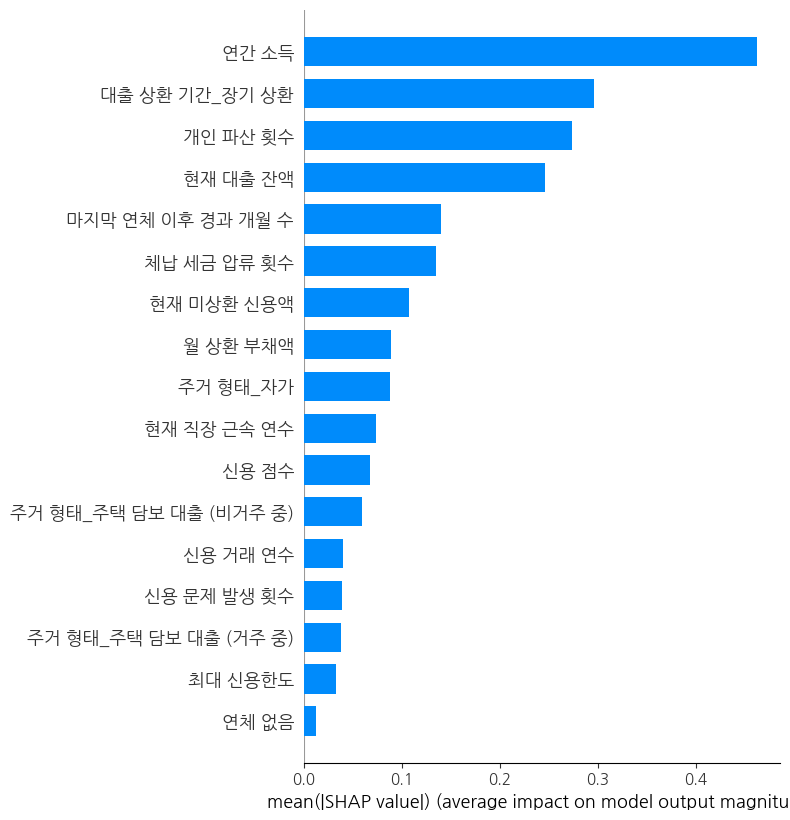

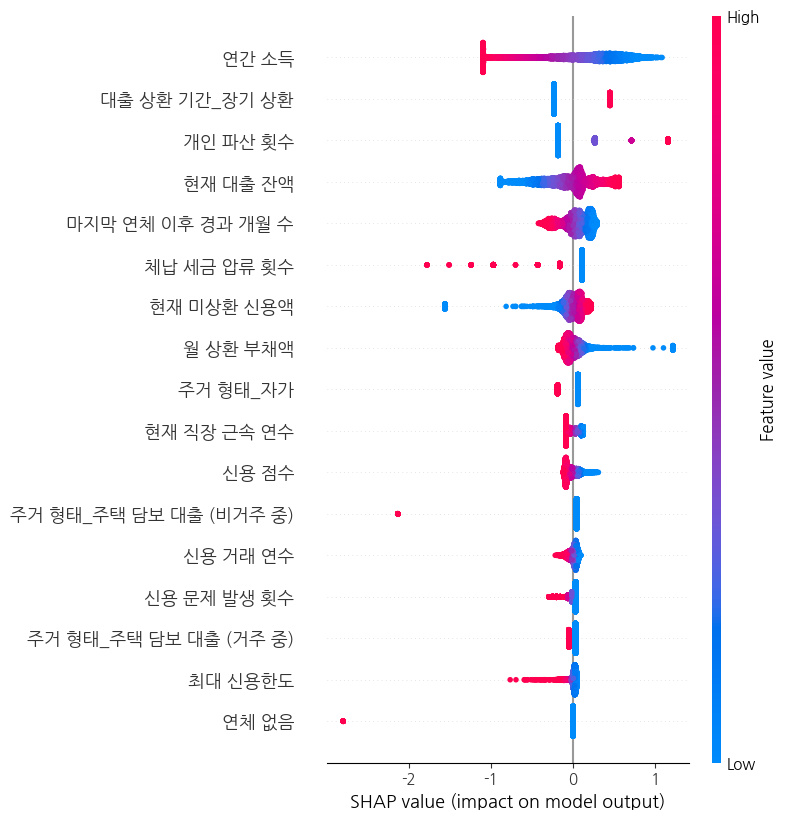

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Explainer 생성
explainer = shap.Explainer(sgd_model, X_train, feature_names=X.columns)

# 2. SHAP 값 계산
shap_values = explainer(X_train)

# 3. 요약 플롯 (전체 변수 영향력 순위 + 분포)
shap.summary_plot(shap_values, X_train, plot_type="bar")     # 중요도 막대형
shap.summary_plot(shap_values, X_train)                       # 분포 시각화